In [30]:
import numpy as np
import pandas as pd

from functools import reduce, partial
from toolz.curried import compose
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
plt.rcParams['figure.figsize'] = (15, 6)
sns.set_style("darkgrid")

In [2]:
dict_from_keys_vals = compose(dict, zip)

We import the information from the Excel file

In [3]:
table = pd.read_excel('phones.xlsx')
table.index = table['ID']
table = table.drop('ID', axis=1)

In [4]:
table

,Price (CAD),Processor Speed (GHz),Capacity (GB),Rear camera resolution (MP),Battery capacity (mAh)
ID,,,,,
iPhone XS 64,1379.00,2.40,64,12.0,2658
iPhone XS 256,1589.00,2.40,256,12.0,2658
iPhone XS 512,1859.00,2.40,512,12.0,2658
Galaxy Note 9 128,900.00,2.70,128,12.0,4000
Galaxy note 9 512,1449.00,2.70,512,12.0,4000
Galaxy Note 8,750.00,2.35,64,12.0,3300
Pixel 3 64,800.00,2.50,64,12.2,2915
Pixel 3 128,1215.00,2.50,128,12.2,2915
Moto Z3,470.00,2.35,64,12.0,3000


### We create a dictionnary to easily map from the criteria to their respective weights.

In [5]:
criteria = table.columns
weights  = [0.3, 0.1, 0.2, 0.15, 0.25]

if len(criteria) == len(weights) and np.isclose(1, reduce(lambda x, y: x + y, weights, 0)):
    w_criteria = dict_from_keys_vals(criteria, weights)
    # w_criteria = {criterion:weight for criterion, weight in zip(criteria, weights)}
else:
    print(f'Number of criteria: {len(criteria)}, number of weights: {len(weights)}')
    print(f'Sum of weights: {sum(weight for weight in weights)}')
    w_criteria = {}
    raise Exception(f'A weight is needed for each criterion and the sum of weights must be equal to one!')

w_criteria

{'Price (CAD)': 0.3,
 'Processor Speed (GHz)': 0.1,
 'Capacity (GB)': 0.2,
 'Rear camera resolution (MP)': 0.15,
 'Battery capacity (mAh)': 0.25}

### We create a dictionary to access the optimization direction (min or max) for each criterion

In [7]:
senses = [0, 1, 1, 1, 1] # O and 1 because they automatically map to complementary bool values. 

if len(senses) == len(criteria):
    s_criteria = dict_from_keys_vals(criteria, senses)
else:
    raise Exception(f'Specify a value (0 for min, 1 for max) for each one of the criteria : {list(criteria)}')
    
s_criteria

{'Price (CAD)': 0,
 'Processor Speed (GHz)': 1,
 'Capacity (GB)': 1,
 'Rear camera resolution (MP)': 1,
 'Battery capacity (mAh)': 1}

## Create the normalised decision matrix

For the normalisation part, there are many possible rules. The following options are available on this implementation: 

1. Each entry is divided by the norm of criterion vector to which it belongs.
   
   $$ x_{ij} \;\; = \;\; \frac{a_{ij}}{\sqrt{\sum_{i}^{N} a_{ij}^{2}}} \;\; \forall i \in E_{row} \; \wedge \; \forall j \in E_{col} $$
    
    
2. Using the maximum AND minimun values of each criterion (column vector), as well the range between them. The map goes as follows:
    
    $$ f: x \longrightarrow y \;\; | \;\; f(min(x)) \rightarrow 0 \; \wedge \; f(max(x)) \rightarrow 1 $$
    
    If the sense of optimisation is MIN:
    $$ x_{ij} \;\; = \frac{\max(r_{j}) - r_{ij}}{\max(r_{j}) - \min(r_{j})} \;\; \forall r_{j} \in Columns $$ 
    
    If the sense of optimisation is MAX:
    $$ x_{ij} \;\; = \frac{r_{ij} - \min(r_{j}) }{\max(r_{j}) - \min(r_{j})} \;\; \forall r_{j} \in Columns $$ 
    
3. Using the maximum OR minimum values, depending on the optimisation criterion for each characteristic.
    
    For non-beneficial characteristics, which we want to minimise:
    $$ x_{ij} = \frac{\min(x_{j})}{x_{ij}} \;\; \forall j \in E_{col} $$
    
    For beneficial characteristics, which we want to maximise:
    $$ x_{ij} = \frac{x_{ij}}{\max(x_{j})} \;\; \forall j \in E_{col} $$
    
4. Centering around zero and have all variances in the same order.

    SciKit-Learn's preprocessing.scale()

### Choose the normalisation rule

In [34]:
normalisation_rule = 2

In [35]:
n_table = table.copy()

if normalisation_rule == 1:
    sq_sum_squares = table.apply(lambda y: np.sqrt(sum(x**2 for x in y)))
    sq_sum_squares = dict(sq_sum_squares)

    for column in table.columns:
        f = (lambda y: lambda x: x/sq_sum_squares[y])(column) 
        n_table[column] = table[column].map(f)
        
elif normalisation_rule == 2:
    denom = dict(table.copy().apply(lambda x: x.max() - x.min()))
    _min  = dict(table.copy().apply(lambda x: x.min()))
    _max  = dict(table.copy().apply(lambda x: x.max()))
    
    norm_min = lambda _key, element: (_max[_key] - element) / denom[_key]
    norm_max = lambda _key, element: (element - _min[_key]) / denom[_key]
    
    for column in table.columns:
        if s_criteria[column]: # if True (==1), use the maximisation rule.  
            n_table[column] = table[column].map(partial(norm_max, column))
            
        else: # if False (==0), use the minimisation rule.
            n_table[column] = table[column].map(partial(norm_min, column))

elif normalisation_rule == 3:
    _min  = dict(table.copy().apply(lambda x: x.min()))
    _max  = dict(table.copy().apply(lambda x: x.max()))
    
    norm_min = lambda _key, element: _min[_key] / element
    norm_max = lambda _key, element: element / _max[_key]
    
    for column in table.columns:
        if s_criteria[column]: # if True (==1), use the maximisation rule.  
            n_table[column] = table[column].map(partial(norm_max, column))
            
        else: # if False (==0), use the minimisation rule.
            n_table[column] = table[column].map(partial(norm_min, column))

elif normalisation_rule == 4:
    
    for column in table.columns:
        n_table[column] = preprocessing.scale(table[column])

else:
    raise Exception('Invalid Normalization Rule')
    

#sns.boxplot(n_table['Price (CAD)'])
#plt.title(f'Normalisation rule: {normalisation_rule}')

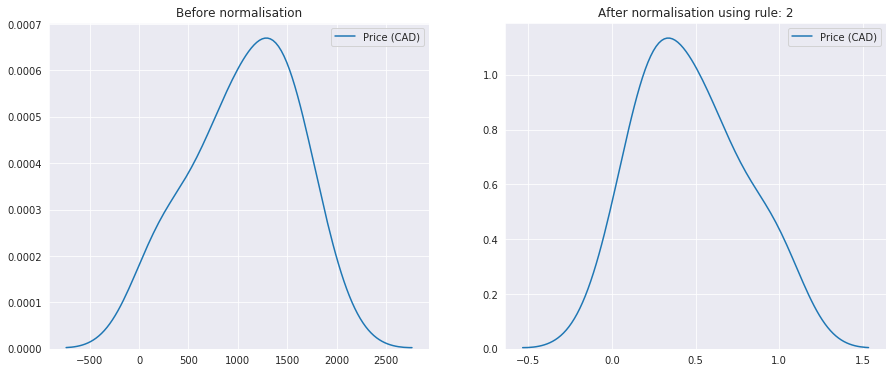

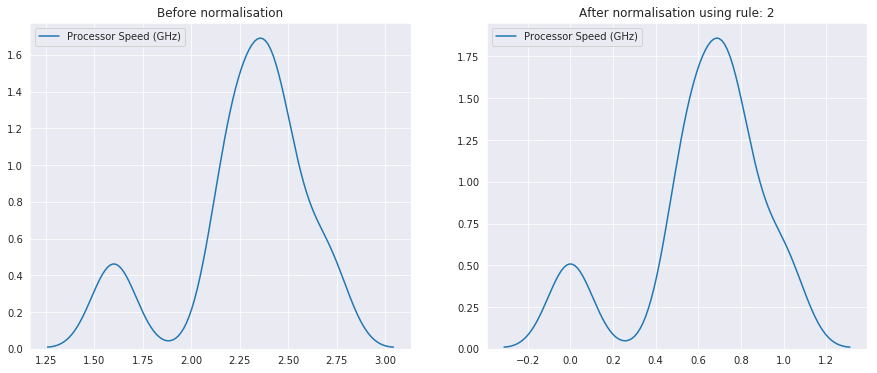

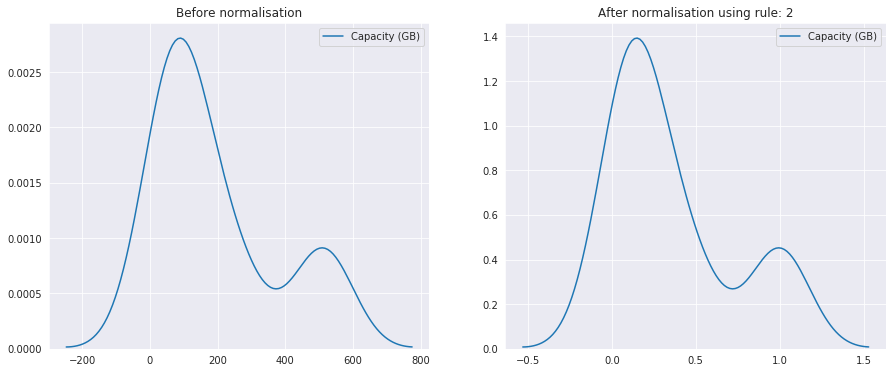

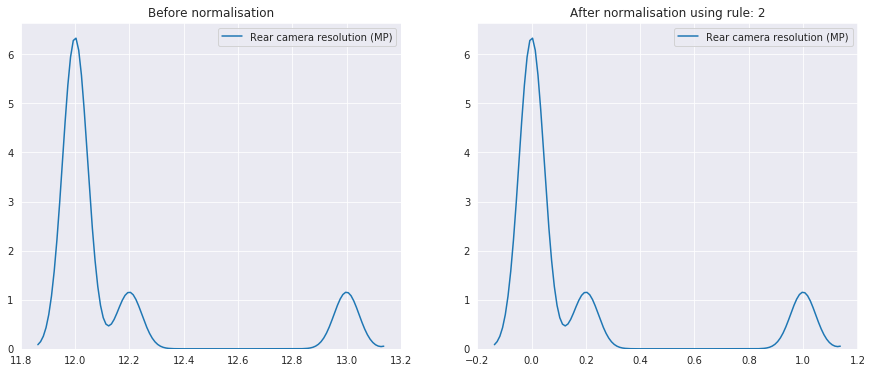

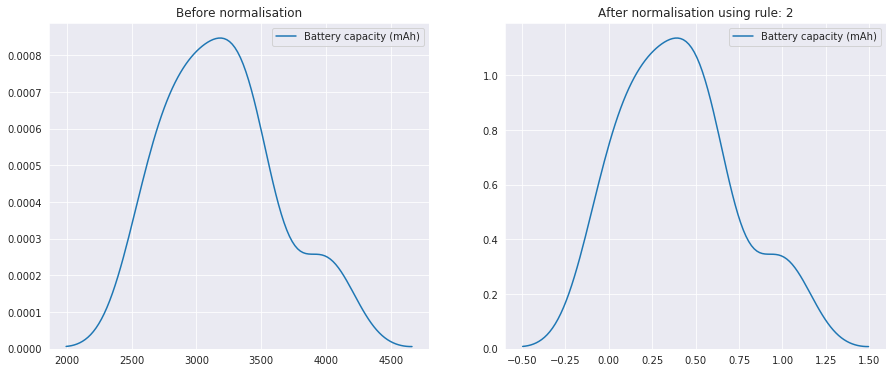

In [36]:
for i, column in enumerate(n_table.columns):
    plt.figure(i)
    plt.title(f'Criteria: {column}')
    plt.subplot(1, 2, 1)
    sns.kdeplot(table[column])
    plt.title(f'Before normalisation')
    plt.subplot(1, 2, 2)
    sns.kdeplot(n_table[column])
    plt.title(f'After normalisation using rule: {normalisation_rule}')

### Create the weighted normalised decision matrix

In [63]:
w_n_table = n_table.copy()

for column in n_table.columns: 
    w_n_table[column] = n_table[column].map(lambda x: x*w_criteria[column])
    
w_n_table.head(5)

,Price (CAD),Processor Speed (GHz),Capacity (GB),Rear camera resolution (MP),Battery capacity (mAh)
ID,,,,,
iPhone XS 64,0.090949,0.026852,0.012795,0.038206,0.053281
iPhone XS 256,0.104799,0.026852,0.051182,0.038206,0.053281
iPhone XS 512,0.122606,0.026852,0.102364,0.038206,0.053281
Galaxy Note 9 128,0.059357,0.030209,0.025591,0.038206,0.080183
Galaxy note 9 512,0.095565,0.030209,0.102364,0.038206,0.080183


### Computation of the concordance matrix

In [93]:
concordance_matrix = pd.DataFrame(columns=table.index, index=table.index)

for phone in w_n_table.index:
    for phone2 in w_n_table.index:
        _sum = 0
        for criterion in w_n_table.columns:
            if w_n_table.loc[phone, criterion] >= w_n_table.loc[phone2, criterion]:
                _sum += w_criteria[criterion]
        if phone == phone2:
            concordance_matrix.loc[phone, phone2] = 0
        else:
            concordance_matrix.loc[phone, phone2] = _sum
        
concordance_matrix

ID,iPhone XS 64,iPhone XS 256,iPhone XS 512,Galaxy Note 9 128,Galaxy note 9 512,Galaxy Note 8,Pixel 3 64,Pixel 3 128,Moto Z3,Galaxy s10e 128,Galaxy s10e 256,Galaxy s10 128,Galaxy s10 512,Galaxy M10 16,Galaxy M10 32
ID,,,,,,,,,,,,,,,
iPhone XS 64,0,0.5,0.5,0.45,0.15,0.75,0.5,0.3,0.75,0.55,0.55,0.25,0.25,0.6,0.6
iPhone XS 256,1,0,0.5,0.65,0.45,0.75,0.5,0.5,0.75,0.75,0.75,0.75,0.25,0.6,0.6
iPhone XS 512,1,1,0,0.65,0.65,0.75,0.5,0.5,0.75,0.75,0.75,0.75,0.75,0.6,0.6
Galaxy Note 9 128,0.7,0.5,0.5,0,0.5,1,0.85,0.55,1,0.7,0.5,0.7,0.5,0.85,0.85
Galaxy note 9 512,1,0.7,0.7,1,0,1,0.85,0.85,1,1,1,1,0.7,0.85,0.85
Galaxy Note 8,0.6,0.4,0.4,0.15,0.15,0,0.45,0.25,1,0.5,0.5,0.25,0.25,0.6,0.6
Pixel 3 64,0.7,0.5,0.5,0.15,0.15,0.75,0,0.5,0.75,0.25,0.25,0.25,0.25,0.6,0.6
Pixel 3 128,0.7,0.5,0.5,0.65,0.15,0.75,1,0,0.75,0.75,0.55,0.45,0.25,0.6,0.6
Moto Z3,0.6,0.4,0.4,0.15,0.15,0.45,0.45,0.25,0,0.25,0.25,0.25,0.25,0.6,0.6


### Binary concordance set

In [106]:
binary_concordance_matrix = concordance_matrix.copy()

sum_of_sums_of_columns = sum(concordance_matrix[column].sum() for column in concordance_matrix.columns)
non_diagonal_entries = concordance_matrix.shape[0]**2 - concordance_matrix.shape[0]
c_bar = sum_of_sums_of_columns / non_diagonal_entries

binary_concordance_matrix = concordance_matrix.applymap(lambda x: 1 if x > c_bar else 0)

binary_concordance_matrix

ID,iPhone XS 64,iPhone XS 256,iPhone XS 512,Galaxy Note 9 128,Galaxy note 9 512,Galaxy Note 8,Pixel 3 64,Pixel 3 128,Moto Z3,Galaxy s10e 128,Galaxy s10e 256,Galaxy s10 128,Galaxy s10 512,Galaxy M10 16,Galaxy M10 32
ID,,,,,,,,,,,,,,,
iPhone XS 64,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1
iPhone XS 256,1,0,0,1,0,1,0,0,1,1,1,1,0,1,1
iPhone XS 512,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1
Galaxy Note 9 128,1,0,0,0,0,1,1,0,1,1,0,1,0,1,1
Galaxy note 9 512,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
Galaxy Note 8,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
Pixel 3 64,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1
Pixel 3 128,1,0,0,1,0,1,1,0,1,1,0,0,0,1,1
Moto Z3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [ ]:
negatives = lambda y: list(filter(lambda x: True if x < 0 else False, y))
positives = lambda y: list(filter(lambda x: True if x > 0 else False, y))

[-4]